In [8]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configuración para mejores visualizaciones
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [9]:
# Conectar a la base de datos
db_path = '../data/ml_ede_test.db'

# Verificar que el archivo existe
if not Path(db_path).exists():
    print(f"Error: No se encontró la base de datos en {db_path}")
    exit()

conn = sqlite3.connect(db_path)
print(f"✅ Conexión exitosa a la base de datos: {db_path}")

# Ver las tablas disponibles
tables_query = """
SELECT 
    name as table_name,
    sql as create_statement
FROM sqlite_master 
WHERE type='table' AND name NOT LIKE 'sqlite_%'
ORDER BY name;
"""

tables_df = pd.read_sql_query(tables_query, conn)
print(f"\n📊 Tablas encontradas en la base de datos ({len(tables_df)} total):")
print(tables_df['table_name'].tolist())

✅ Conexión exitosa a la base de datos: ../data/ml_ede_test.db

📊 Tablas encontradas en la base de datos (3 total):
['study_instances', 'study_patient_data', 'study_report']


In [10]:
# Función para explorar cada tabla
def explore_table(conn, table_name):
    print(f"\n{'='*60}")
    print(f"🔍 EXPLORANDO TABLA: {table_name.upper()}")
    print(f"{'='*60}")
    
    # Obtener información de la estructura
    schema_query = f"PRAGMA table_info({table_name})"
    schema_df = pd.read_sql_query(schema_query, conn)
    
    print(f"\n📋 Estructura de la tabla '{table_name}':")
    print(schema_df[['name', 'type', 'notnull', 'pk']].to_string(index=False))
    
    # Contar registros
    count_query = f"SELECT COUNT(*) as total_rows FROM {table_name}"
    total_rows = pd.read_sql_query(count_query, conn)['total_rows'].iloc[0]
    print(f"\n📈 Total de registros: {total_rows:,}")
    
    if total_rows == 0:
        print("⚠️  La tabla está vacía")
        return None
    
    # Obtener muestra de datos
    sample_query = f"SELECT * FROM {table_name} LIMIT 1000"
    df = pd.read_sql_query(sample_query, conn)
    
    print(f"\n🔢 Información del DataFrame (muestra de {len(df)} registros):")
    df.info()
    
    print(f"\n👀 Primeras 5 filas:")
    print(df.head())
    
    # Estadísticas descriptivas para columnas numéricas
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        print(f"\n📊 Estadísticas descriptivas (columnas numéricas):")
        print(df[numeric_cols].describe())
    
    # Verificar valores nulos
    null_counts = df.isnull().sum()
    if null_counts.sum() > 0:
        print(f"\n❌ Valores nulos por columna:")
        print(null_counts[null_counts > 0])
    else:
        print(f"\n✅ No hay valores nulos en la muestra")
    
    # Para columnas categóricas, mostrar valores únicos
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        unique_vals = df[col].nunique()
        if unique_vals <= 20:  # Solo mostrar si hay pocos valores únicos
            print(f"\n🏷️  Valores únicos en '{col}' ({unique_vals} total):")
            print(df[col].value_counts().head(10))
        else:
            print(f"\n🏷️  Columna '{col}': {unique_vals} valores únicos")
    
    return df

# Explorar todas las tablas
table_data = {}
for table_name in tables_df['table_name']:
    table_data[table_name] = explore_table(conn, table_name)


🔍 EXPLORANDO TABLA: STUDY_INSTANCES

📋 Estructura de la tabla 'study_instances':
            name type  notnull  pk
        study_id TEXT        0   0
     instance_id TEXT        0   0
measurement_data TEXT        0   0
       file_name TEXT        0   0

📈 Total de registros: 460

🔢 Información del DataFrame (muestra de 460 registros):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460 entries, 0 to 459
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   study_id          460 non-null    object
 1   instance_id       460 non-null    object
 2   measurement_data  460 non-null    object
 3   file_name         460 non-null    object
dtypes: object(4)
memory usage: 14.5+ KB

👀 Primeras 5 filas:
                               study_id                           instance_id  \
0  003b88ed-bdd5-4bac-89b2-c170d9418d75  f450b733-2665-4c5a-b640-667bf383c1f3   
1  0084943c-8a11-467d-b1f4-2ff0c0d8aeff  9d24fc05-0a41-

In [11]:
# Resumen general de la base de datos
print(f"\n{'='*80}")
print(f"📋 RESUMEN GENERAL DE LA BASE DE DATOS")
print(f"{'='*80}")

total_tables = len(tables_df)
total_records = 0

for table_name in tables_df['table_name']:
    count_query = f"SELECT COUNT(*) as total_rows FROM {table_name}"
    rows = pd.read_sql_query(count_query, conn)['total_rows'].iloc[0]
    total_records += rows
    print(f"  • {table_name}: {rows:,} registros")

print(f"\n📊 Total de tablas: {total_tables}")
print(f"📊 Total de registros: {total_records:,}")

# Verificar relaciones entre tablas (claves foráneas)
print(f"\n🔗 Verificando relaciones entre tablas...")
for table_name in tables_df['table_name']:
    fk_query = f"PRAGMA foreign_key_list({table_name})"
    fk_df = pd.read_sql_query(fk_query, conn)
    if not fk_df.empty:
        print(f"  • {table_name} tiene claves foráneas:")
        for _, row in fk_df.iterrows():
            print(f"    - {row['from']} → {row['table']}.{row['to']}")


📋 RESUMEN GENERAL DE LA BASE DE DATOS
  • study_instances: 460 registros
  • study_patient_data: 549 registros
  • study_report: 555 registros

📊 Total de tablas: 3
📊 Total de registros: 1,564

🔗 Verificando relaciones entre tablas...


In [12]:
# Análisis de calidad de datos más detallado
print(f"\n📊 ANÁLISIS DE CALIDAD DE DATOS")
print(f"{'='*80}")

data_quality_summary = {}

for table_name, df in table_data.items():
    if df is not None and not df.empty:
        print(f"\n🔍 Tabla: {table_name}")
        print("-" * 40)
        
        quality_info = {
            'total_rows': len(df),
            'total_columns': len(df.columns),
            'numeric_columns': len(df.select_dtypes(include=[np.number]).columns),
            'categorical_columns': len(df.select_dtypes(include=['object']).columns),
            'missing_values': df.isnull().sum().sum(),
            'duplicate_rows': df.duplicated().sum(),
            'completeness': (1 - df.isnull().sum().sum() / (len(df) * len(df.columns))) * 100
        }
        
        data_quality_summary[table_name] = quality_info
        
        print(f"  📏 Dimensiones: {quality_info['total_rows']:,} filas × {quality_info['total_columns']} columnas")
        print(f"  🔢 Columnas numéricas: {quality_info['numeric_columns']}")
        print(f"  🏷️  Columnas categóricas: {quality_info['categorical_columns']}")
        print(f"  ❌ Valores faltantes: {quality_info['missing_values']:,}")
        print(f"  🔄 Filas duplicadas: {quality_info['duplicate_rows']:,}")
        print(f"  ✅ Completitud: {quality_info['completeness']:.1f}%")
        
        # Detectar posibles problemas de calidad
        problems = []
        if quality_info['missing_values'] > 0:
            problems.append(f"Valores faltantes ({quality_info['missing_values']})")
        if quality_info['duplicate_rows'] > 0:
            problems.append(f"Filas duplicadas ({quality_info['duplicate_rows']})")
        if quality_info['completeness'] < 90:
            problems.append(f"Baja completitud ({quality_info['completeness']:.1f}%)")
        
        if problems:
            print(f"  ⚠️  Problemas detectados: {', '.join(problems)}")
        else:
            print(f"  ✅ No se detectaron problemas importantes")

# Crear un DataFrame resumen de calidad
quality_df = pd.DataFrame(data_quality_summary).T
print(f"\n📋 RESUMEN DE CALIDAD POR TABLA:")
print(quality_df.to_string())


📊 ANÁLISIS DE CALIDAD DE DATOS

🔍 Tabla: study_instances
----------------------------------------
  📏 Dimensiones: 460 filas × 4 columnas
  🔢 Columnas numéricas: 0
  🏷️  Columnas categóricas: 4
  ❌ Valores faltantes: 0
  🔄 Filas duplicadas: 0
  ✅ Completitud: 100.0%
  ✅ No se detectaron problemas importantes

🔍 Tabla: study_patient_data
----------------------------------------
  📏 Dimensiones: 549 filas × 5 columnas
  🔢 Columnas numéricas: 0
  🏷️  Columnas categóricas: 5
  ❌ Valores faltantes: 0
  🔄 Filas duplicadas: 0
  ✅ Completitud: 100.0%
  ✅ No se detectaron problemas importantes

🔍 Tabla: study_report
----------------------------------------
  📏 Dimensiones: 555 filas × 3 columnas
  🔢 Columnas numéricas: 0
  🏷️  Columnas categóricas: 3
  ❌ Valores faltantes: 0
  🔄 Filas duplicadas: 0
  ✅ Completitud: 100.0%
  ✅ No se detectaron problemas importantes

📋 RESUMEN DE CALIDAD POR TABLA:
                    total_rows  total_columns  numeric_columns  categorical_columns  missing_value


📈 ANÁLISIS COMPLETO DE TODAS LAS VARIABLES

📊 ANÁLISIS COMPLETO DE TABLA: STUDY_INSTANCES

📋 Clasificación de columnas:
  • Columnas numéricas: [] (0 total)
  • Columnas categóricas: [] (0 total)
  • Columnas de texto: ['measurement_data', 'file_name'] (2 total)
  • Columnas de ID: ['study_id', 'instance_id'] (2 total)

📝 ANÁLISIS DE VARIABLES DE TEXTO
--------------------------------------------------

📊 Análisis de: measurement_data
  📈 Estadísticas de texto:
    - Total de registros: 460
    - Textos únicos: 460
    - Longitud promedio: 982.1 caracteres
    - Longitud mínima: 814 caracteres
    - Longitud máxima: 1149 caracteres
    - Palabras promedio: 86.8
    - Textos vacíos: 0


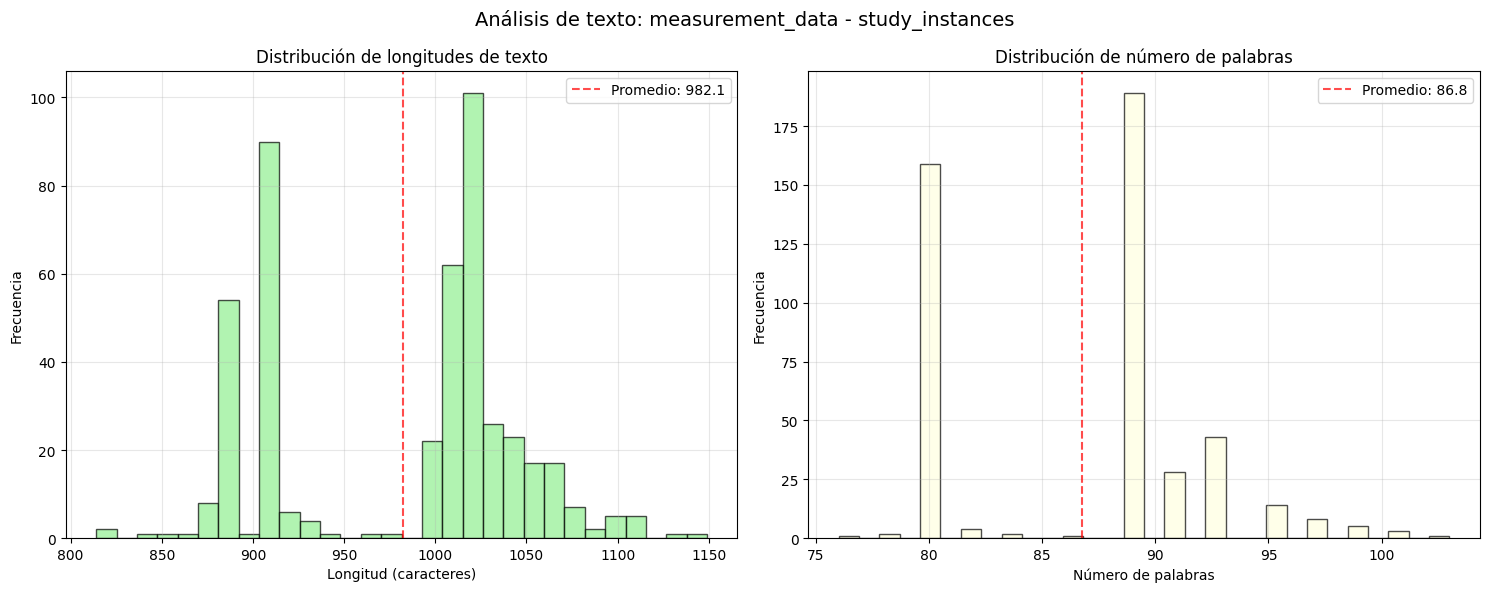

  📄 Ejemplos de contenido:
    Ejemplo 1: [{"ctr": 85.73, "uuid": "e6c3a30d-5786-4297-ab28-48fd19c097a4", "value": "85.73%", "active": true, "handles": {"end": {"x": 1543.3241379310346, "y": 1558.1905172413794, "active": false, "moving": fals...
    Ejemplo 2: [{"ctr": 66.54, "uuid": "40a20730-ef63-49e4-ae94-b9d4fb7a453f", "value": "66.54%", "active": true, "handles": {"end": {"x": 382.11285528017066, "y": 312.0352264588477, "active": false, "moving": false...
    Ejemplo 3: [{"ctr": 46.16, "uuid": "a0ca5b2d-0fa4-4aee-979c-af9440f2bf7d", "value": "46.16%", "active": true, "handles": {"end": {"x": 2784.369016536119, "y": 2845.883376849434, "active": false, "moving": false,...

📊 Análisis de: file_name
  📈 Estadísticas de texto:
    - Total de registros: 460
    - Textos únicos: 327
    - Longitud promedio: 8.2 caracteres
    - Longitud mínima: 5 caracteres
    - Longitud máxima: 56 caracteres
    - Palabras promedio: 1.0
    - Textos vacíos: 0


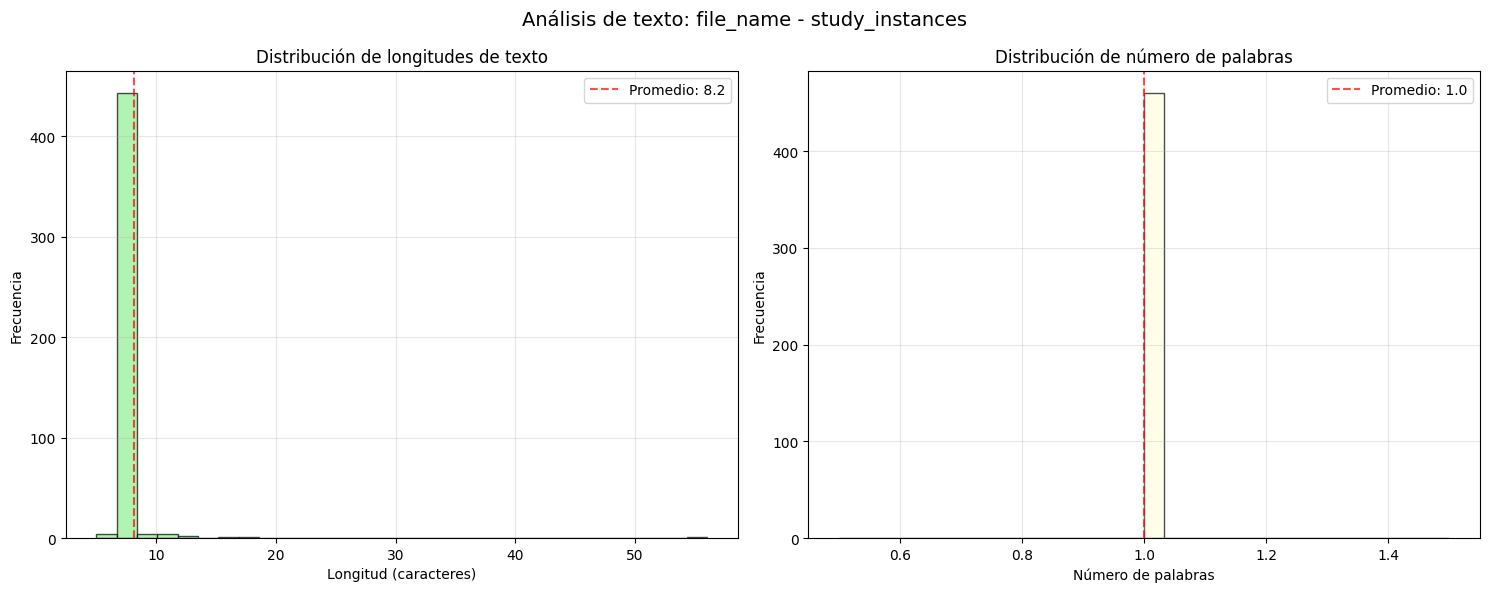

  📄 Ejemplos de contenido:
    Ejemplo 1: 80D1627D
    Ejemplo 2: D4E52883
    Ejemplo 3: 9988B8C4

🆔 ANÁLISIS DE IDENTIFICADORES
--------------------------------------------------

📊 Análisis de: study_id
  📈 Estadísticas de ID:
    - Total de valores: 460
    - Valores únicos: 328
    - Valores faltantes: 0
    - Valores duplicados: 132
    - Unicidad: 71.3%
  🔍 Ejemplos de IDs: ['003b88ed-bdd5-4bac-89b2-c170d9418d75', '0084943c-8a11-467d-b1f4-2ff0c0d8aeff', '00b5f7cf-1ef4-43bc-a8b8-0f36a15f4b5e', '00ea3632-3e1d-4a7d-82ab-97396b8bad0c', '00ea3632-3e1d-4a7d-82ab-97396b8bad0c']
  ✅ Formato: UUIDs válidos detectados
  ⚠️ IDs duplicados más frecuentes:
    - ab42f22c-d740-4b8c-91cd-25881770e626: 6 repeticiones
    - dce130c5-a4b2-4469-9a5f-14216ea0b38e: 6 repeticiones
    - 17119845-6509-4e98-b880-15ac6b8a05f6: 6 repeticiones
    - 204a1ef3-f661-4d01-b128-db1f5d18cb02: 5 repeticiones
    - 16827176-a53a-4dd9-bd4a-867892f891a9: 5 repeticiones

📊 Análisis de: instance_id
  📈 Estadísticas d

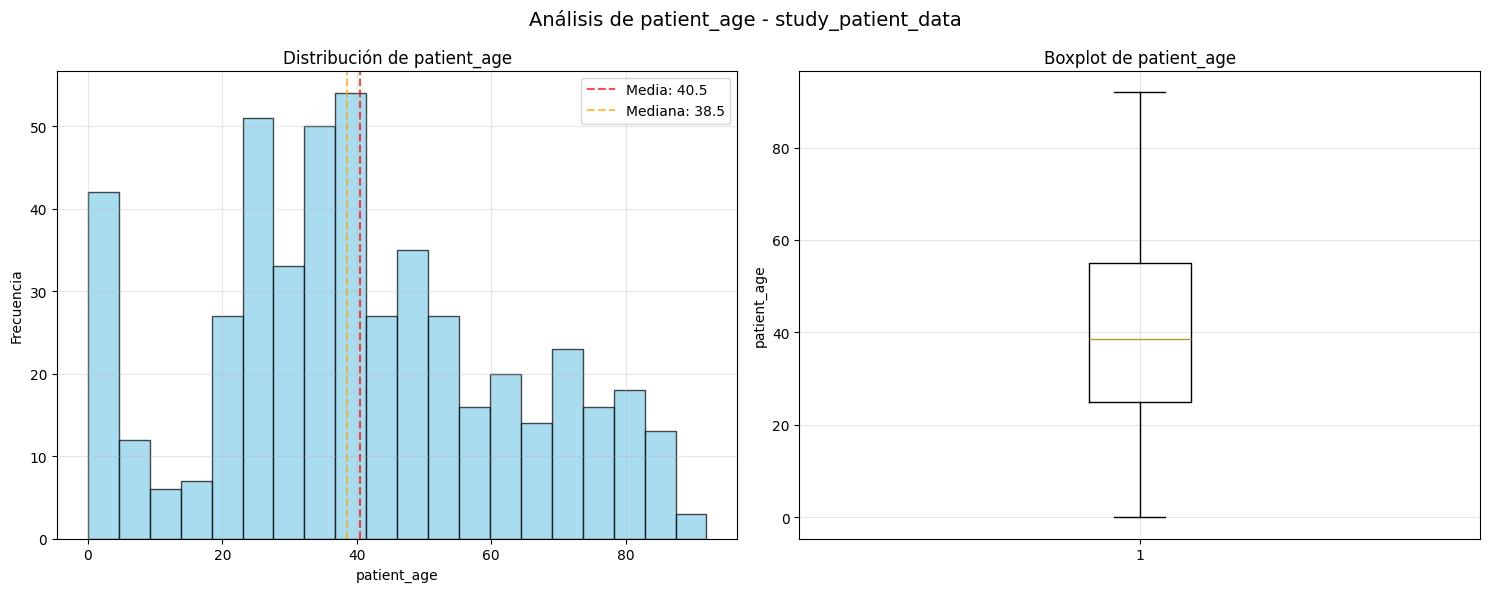


🏷️ ANÁLISIS DE VARIABLES CATEGÓRICAS
--------------------------------------------------

📊 Análisis de: modalities
  📈 Estadísticas:
    - Valores únicos: 4
    - Valores faltantes: 0
    - Moda: DX (272 ocurrencias)
  📋 Distribución completa:
    - DX: 272 (49.5%)
    - CR: 231 (42.1%)
    - DR: 24 (4.4%)
    - CT: 22 (4.0%)


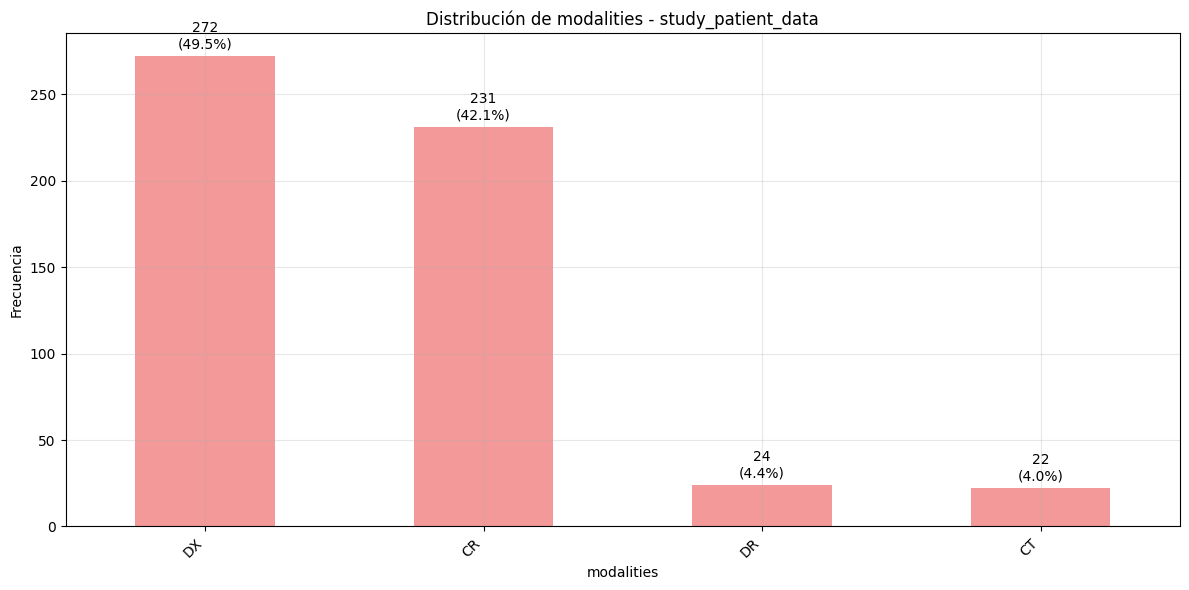


📊 Análisis de: patient_gender
  📈 Estadísticas:
    - Valores únicos: 3
    - Valores faltantes: 0
    - Moda: M (287 ocurrencias)
  📋 Distribución completa:
    - M: 287 (52.3%)
    - F: 256 (46.6%)
    - O: 6 (1.1%)


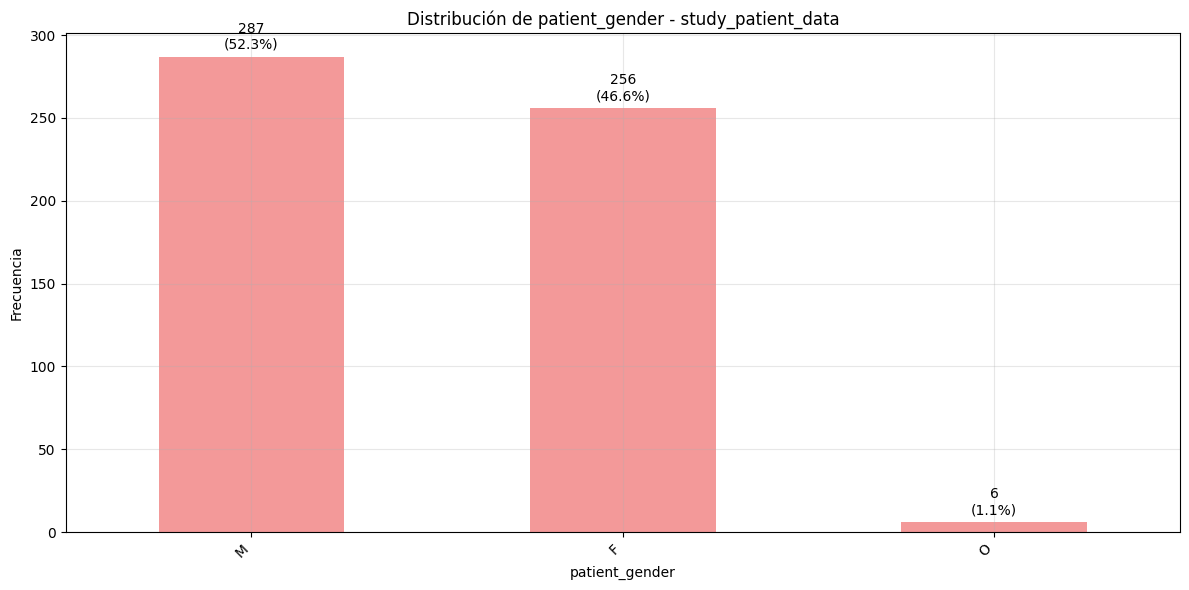


📝 ANÁLISIS DE VARIABLES DE TEXTO
--------------------------------------------------

📊 Análisis de: body_parts
  📈 Estadísticas de texto:
    - Total de registros: 549
    - Textos únicos: 68
    - Longitud promedio: 8.4 caracteres
    - Longitud mínima: 3 caracteres
    - Longitud máxima: 65 caracteres
    - Palabras promedio: 1.2
    - Textos vacíos: 0


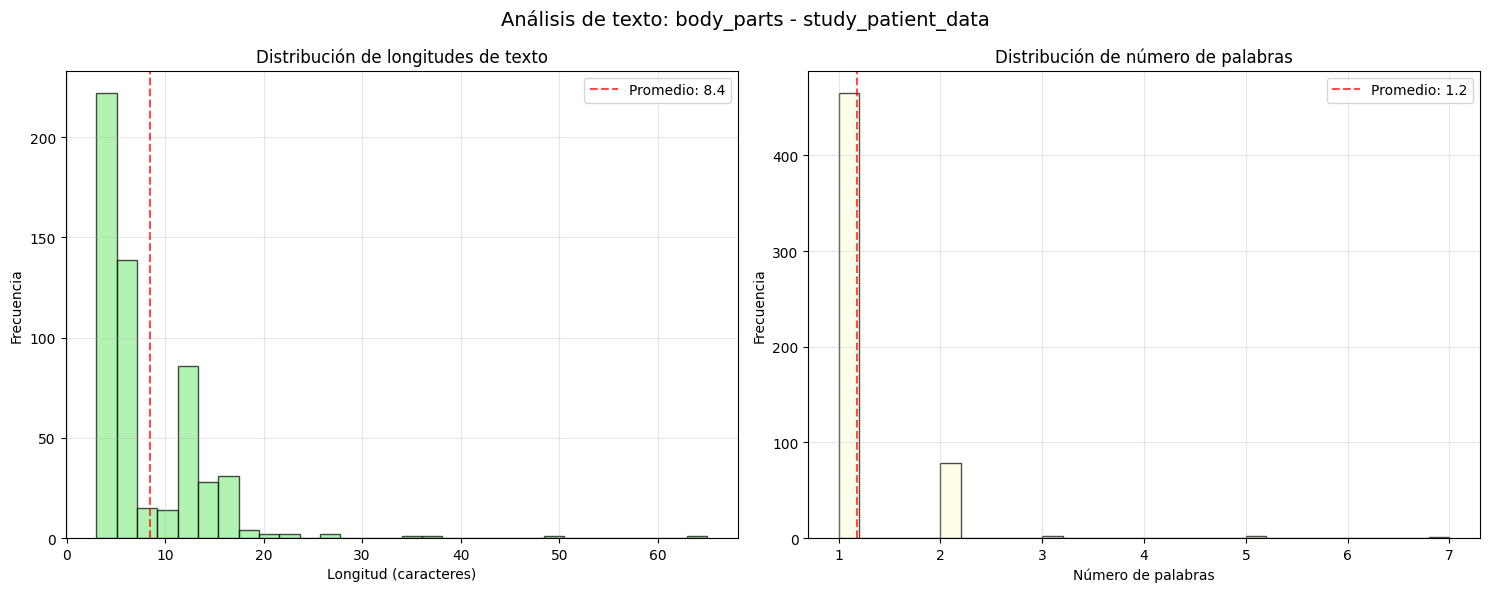

  📄 Ejemplos de contenido:
    Ejemplo 1: LSPINE
    Ejemplo 2: ABDOMEN,OTHER
    Ejemplo 3: CHEST

🆔 ANÁLISIS DE IDENTIFICADORES
--------------------------------------------------

📊 Análisis de: study_id
  📈 Estadísticas de ID:
    - Total de valores: 549
    - Valores únicos: 549
    - Valores faltantes: 0
    - Valores duplicados: 0
    - Unicidad: 100.0%
  🔍 Ejemplos de IDs: ['003b88ed-bdd5-4bac-89b2-c170d9418d75', '0084943c-8a11-467d-b1f4-2ff0c0d8aeff', '00b5f7cf-1ef4-43bc-a8b8-0f36a15f4b5e', '00ea3632-3e1d-4a7d-82ab-97396b8bad0c', '00f65e49-5127-4149-9af2-f06a97d3e84a']
  ✅ Formato: UUIDs válidos detectados

📋 RESUMEN GENERAL DE LA TABLA 'study_patient_data'
--------------------------------------------------
  • Dimensiones: 549 filas × 5 columnas
  • Memoria utilizada: 135.8 KB
  • Tipos de columnas:
    - Numéricas: 1
    - Categóricas: 2
    - Texto: 1
    - Identificadores: 1
  • Calidad de datos:
    - Completitud: 98.0%
    - Celdas faltantes: 55 de 2,745
    - Filas dupli

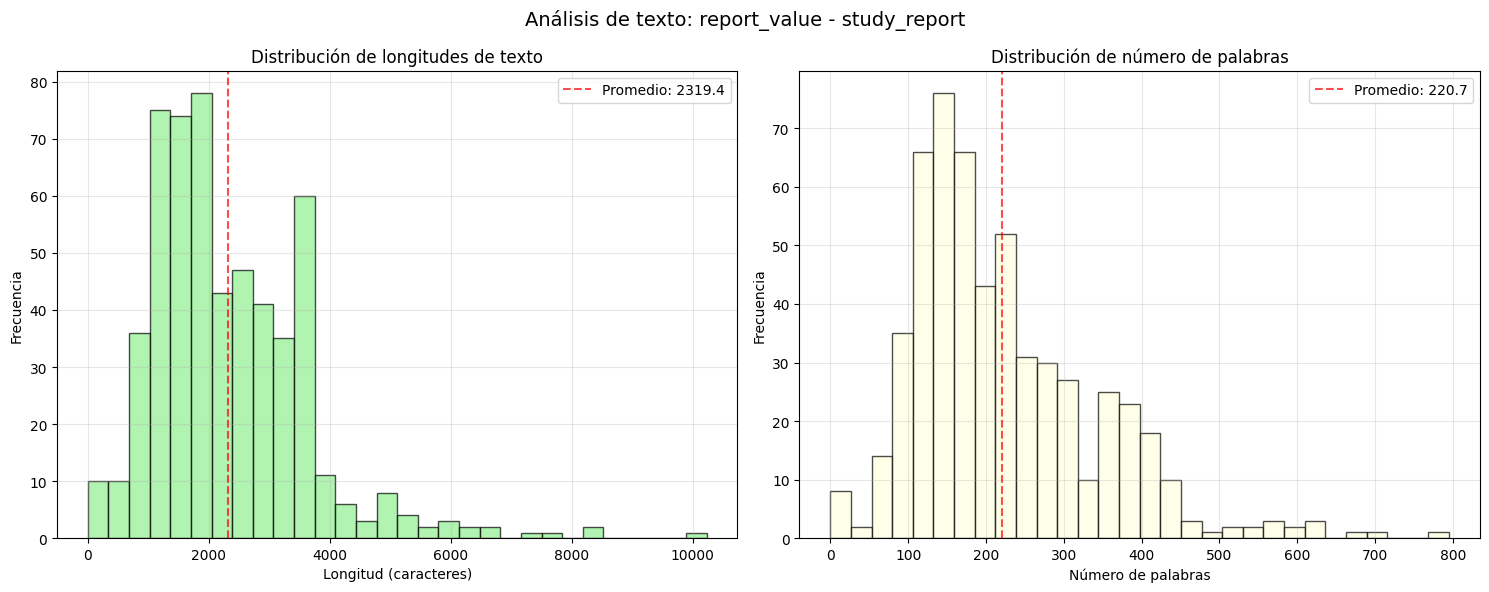

  📄 Ejemplos de contenido:
    Ejemplo 1: <p><strong>Descripci&oacute;n del procedimiento realizado y hallazgos.</strong></p> <p><br />En <strong>teleradiograf&iacute;a del t&oacute;rax</strong> se aprecia la relaci&oacute;n entre partes blan...
    Ejemplo 2: <p><strong>TOMOGRAFIA DE TORAX Y ABDOMEN.</strong></p> <p><strong>&nbsp;</strong></p> <p><strong>T&Eacute;CNICA.</strong></p> <p>Se obtienen im&aacute;genes del t&oacute;rax, abdomen y pelvis desde la...
    Ejemplo 3: <p><strong>T&eacute;cnica.</strong></p> <p>Teleradiograf&iacute;a posteroanterior de t&oacute;rax.</p> <p><strong>&nbsp;</strong></p> <p><strong>Indicaci&oacute;n del estudio.&nbsp; Tos.</strong></p> ...

🆔 ANÁLISIS DE IDENTIFICADORES
--------------------------------------------------

📊 Análisis de: study_id
  📈 Estadísticas de ID:
    - Total de valores: 555
    - Valores únicos: 547
    - Valores faltantes: 0
    - Valores duplicados: 8
    - Unicidad: 98.6%
  🔍 Ejemplos de IDs: ['003b88ed-bdd5-4bac-89b2-c170d94

In [13]:
# Análisis completo de todas las variables en cada tabla
print(f"\n📈 ANÁLISIS COMPLETO DE TODAS LAS VARIABLES")
print(f"{'='*80}")

# Configurar matplotlib para mostrar gráficas inline
%matplotlib inline
plt.rcParams['figure.max_open_warning'] = 0

for table_name, df in table_data.items():
    if df is not None and not df.empty:
        print(f"\n{'='*60}")
        print(f"📊 ANÁLISIS COMPLETO DE TABLA: {table_name.upper()}")
        print(f"{'='*60}")
        
        # Crear copia para análisis con conversiones de tipo apropiadas
        df_analysis = df.copy()
        
        # Identificar y convertir columnas numéricas que están como string
        numeric_conversions = {}
        if 'patient_age' in df.columns:
            df_analysis['patient_age'] = pd.to_numeric(df_analysis['patient_age'], errors='coerce')
            numeric_conversions['patient_age'] = 'edad (años)'
        
        # Categorizar todas las columnas
        categorical_cols = []
        numeric_cols = []
        text_cols = []
        id_cols = []
        
        for col in df_analysis.columns:
            if col in numeric_conversions:
                numeric_cols.append(col)
            elif col.endswith('_id') or 'id' in col.lower():
                id_cols.append(col)
            elif df_analysis[col].dtype == 'object':
                # Determinar si es categórica con pocas categorías o texto largo
                unique_count = df_analysis[col].nunique()
                avg_length = df_analysis[col].astype(str).str.len().mean()
                
                if unique_count <= 50 and avg_length < 100:
                    categorical_cols.append(col)
                else:
                    text_cols.append(col)
            else:
                numeric_cols.append(col)
        
        print(f"\n📋 Clasificación de columnas:")
        print(f"  • Columnas numéricas: {numeric_cols} ({len(numeric_cols)} total)")
        print(f"  • Columnas categóricas: {categorical_cols} ({len(categorical_cols)} total)")  
        print(f"  • Columnas de texto: {text_cols} ({len(text_cols)} total)")
        print(f"  • Columnas de ID: {id_cols} ({len(id_cols)} total)")
        
        # 1. ANÁLISIS DE COLUMNAS NUMÉRICAS
        if numeric_cols:
            print(f"\n🔢 ANÁLISIS DE VARIABLES NUMÉRICAS")
            print("-" * 50)
            
            for col in numeric_cols:
                print(f"\n📊 Análisis de: {col}")
                data = df_analysis[col].dropna()
                
                if len(data) > 0:
                    # Estadísticas descriptivas
                    stats = {
                        'count': len(data),
                        'missing': len(df_analysis) - len(data),
                        'mean': data.mean(),
                        'median': data.median(),
                        'std': data.std(),
                        'min': data.min(),
                        'max': data.max(),
                        'q25': data.quantile(0.25),
                        'q75': data.quantile(0.75)
                    }
                    
                    print(f"  📈 Estadísticas descriptivas:")
                    print(f"    - Valores válidos: {stats['count']:,} ({stats['count']/len(df_analysis)*100:.1f}%)")
                    print(f"    - Valores faltantes: {stats['missing']:,}")
                    print(f"    - Media: {stats['mean']:.2f}")
                    print(f"    - Mediana: {stats['median']:.2f}")
                    print(f"    - Desviación estándar: {stats['std']:.2f}")
                    print(f"    - Mínimo: {stats['min']:.2f}")
                    print(f"    - Máximo: {stats['max']:.2f}")
                    print(f"    - Q1 (25%): {stats['q25']:.2f}")
                    print(f"    - Q3 (75%): {stats['q75']:.2f}")
                    
                    # Crear visualizaciones
                    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
                    fig.suptitle(f'Análisis de {col} - {table_name}', fontsize=14)
                    
                    # Histograma
                    axes[0].hist(data, bins=20, alpha=0.7, edgecolor='black', color='skyblue')
                    axes[0].axvline(stats['mean'], color='red', linestyle='--', alpha=0.7, label=f'Media: {stats["mean"]:.1f}')
                    axes[0].axvline(stats['median'], color='orange', linestyle='--', alpha=0.7, label=f'Mediana: {stats["median"]:.1f}')
                    axes[0].set_title(f'Distribución de {col}')
                    axes[0].set_xlabel(col)
                    axes[0].set_ylabel('Frecuencia')
                    axes[0].legend()
                    axes[0].grid(True, alpha=0.3)
                    
                    # Boxplot
                    axes[1].boxplot(data, vert=True)
                    axes[1].set_title(f'Boxplot de {col}')
                    axes[1].set_ylabel(col)
                    axes[1].grid(True, alpha=0.3)
                    
                    plt.tight_layout()
                    plt.show()
                    
                    # Detectar outliers
                    iqr = stats['q75'] - stats['q25']
                    lower_bound = stats['q25'] - 1.5 * iqr
                    upper_bound = stats['q75'] + 1.5 * iqr
                    outliers = data[(data < lower_bound) | (data > upper_bound)]
                    
                    if len(outliers) > 0:
                        print(f"  ⚠️ Outliers detectados: {len(outliers)} valores ({len(outliers)/len(data)*100:.1f}%)")
                        print(f"    - Rango normal: [{lower_bound:.2f}, {upper_bound:.2f}]")
        
        # 2. ANÁLISIS DE COLUMNAS CATEGÓRICAS
        if categorical_cols:
            print(f"\n🏷️ ANÁLISIS DE VARIABLES CATEGÓRICAS")
            print("-" * 50)
            
            for col in categorical_cols:
                print(f"\n📊 Análisis de: {col}")
                
                value_counts = df_analysis[col].value_counts()
                unique_count = len(value_counts)
                missing_count = df_analysis[col].isnull().sum()
                
                print(f"  📈 Estadísticas:")
                print(f"    - Valores únicos: {unique_count}")
                print(f"    - Valores faltantes: {missing_count}")
                print(f"    - Moda: {value_counts.index[0]} ({value_counts.iloc[0]} ocurrencias)")
                
                # Mostrar distribución completa
                print(f"  📋 Distribución completa:")
                for value, count in value_counts.items():
                    percentage = (count / len(df_analysis)) * 100
                    print(f"    - {value}: {count:,} ({percentage:.1f}%)")
                
                # Crear visualización
                plt.figure(figsize=(12, 6))
                
                # Gráfico de barras
                ax = value_counts.plot(kind='bar', color='lightcoral', alpha=0.8)
                plt.title(f'Distribución de {col} - {table_name}')
                plt.xlabel(col)
                plt.ylabel('Frecuencia')
                plt.xticks(rotation=45, ha='right')
                plt.grid(True, alpha=0.3)
                
                # Agregar valores en las barras
                for i, v in enumerate(value_counts.values):
                    ax.text(i, v + max(value_counts.values) * 0.01, 
                           f'{v}\n({v/len(df_analysis)*100:.1f}%)', 
                           ha='center', va='bottom')
                
                plt.tight_layout()
                plt.show()
        
        # 3. ANÁLISIS DE COLUMNAS DE TEXTO
        if text_cols:
            print(f"\n📝 ANÁLISIS DE VARIABLES DE TEXTO")
            print("-" * 50)
            
            for col in text_cols:
                print(f"\n📊 Análisis de: {col}")
                
                # Estadísticas de texto
                text_data = df_analysis[col].astype(str)
                lengths = text_data.str.len()
                word_counts = text_data.str.split().str.len()
                
                stats = {
                    'count': len(text_data),
                    'unique': text_data.nunique(),
                    'avg_length': lengths.mean(),
                    'min_length': lengths.min(),
                    'max_length': lengths.max(),
                    'avg_words': word_counts.mean(),
                    'empty': (text_data == '').sum() + text_data.isnull().sum()
                }
                
                print(f"  📈 Estadísticas de texto:")
                print(f"    - Total de registros: {stats['count']:,}")
                print(f"    - Textos únicos: {stats['unique']:,}")
                print(f"    - Longitud promedio: {stats['avg_length']:.1f} caracteres")
                print(f"    - Longitud mínima: {stats['min_length']:.0f} caracteres")
                print(f"    - Longitud máxima: {stats['max_length']:.0f} caracteres")
                print(f"    - Palabras promedio: {stats['avg_words']:.1f}")
                print(f"    - Textos vacíos: {stats['empty']:,}")
                
                # Crear visualizaciones
                fig, axes = plt.subplots(1, 2, figsize=(15, 6))
                fig.suptitle(f'Análisis de texto: {col} - {table_name}', fontsize=14)
                
                # Distribución de longitudes
                axes[0].hist(lengths, bins=30, alpha=0.7, edgecolor='black', color='lightgreen')
                axes[0].axvline(stats['avg_length'], color='red', linestyle='--', alpha=0.7, 
                               label=f'Promedio: {stats["avg_length"]:.1f}')
                axes[0].set_title('Distribución de longitudes de texto')
                axes[0].set_xlabel('Longitud (caracteres)')
                axes[0].set_ylabel('Frecuencia')
                axes[0].legend()
                axes[0].grid(True, alpha=0.3)
                
                # Distribución de número de palabras
                axes[1].hist(word_counts, bins=30, alpha=0.7, edgecolor='black', color='lightyellow')
                axes[1].axvline(stats['avg_words'], color='red', linestyle='--', alpha=0.7,
                               label=f'Promedio: {stats["avg_words"]:.1f}')
                axes[1].set_title('Distribución de número de palabras')
                axes[1].set_xlabel('Número de palabras')
                axes[1].set_ylabel('Frecuencia')
                axes[1].legend()
                axes[1].grid(True, alpha=0.3)
                
                plt.tight_layout()
                plt.show()
                
                # Mostrar ejemplos de textos
                print(f"  📄 Ejemplos de contenido:")
                for i, text in enumerate(text_data.head(3)):
                    preview = text[:200] + "..." if len(text) > 200 else text
                    print(f"    Ejemplo {i+1}: {preview}")
        
        # 4. ANÁLISIS DE COLUMNAS DE ID
        if id_cols:
            print(f"\n🆔 ANÁLISIS DE IDENTIFICADORES")
            print("-" * 50)
            
            for col in id_cols:
                print(f"\n📊 Análisis de: {col}")
                
                values = df_analysis[col]
                unique_count = values.nunique()
                total_count = len(values)
                missing_count = values.isnull().sum()
                duplicate_count = total_count - unique_count
                
                print(f"  📈 Estadísticas de ID:")
                print(f"    - Total de valores: {total_count:,}")
                print(f"    - Valores únicos: {unique_count:,}")
                print(f"    - Valores faltantes: {missing_count:,}")
                print(f"    - Valores duplicados: {duplicate_count:,}")
                print(f"    - Unicidad: {unique_count/total_count*100:.1f}%")
                
                # Verificar formato de ID
                sample_ids = values.dropna().head(5).tolist()
                print(f"  🔍 Ejemplos de IDs: {sample_ids}")
                
                # Verificar si son UUIDs
                import re
                uuid_pattern = re.compile(r'^[0-9a-f]{8}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{12}$')
                sample_check = values.dropna().head(100)
                uuid_matches = sum(1 for v in sample_check if uuid_pattern.match(str(v).lower()))
                
                if uuid_matches > 90:  # 90% son UUIDs
                    print(f"  ✅ Formato: UUIDs válidos detectados")
                else:
                    print(f"  ℹ️ Formato: No son UUIDs estándar")
                
                if duplicate_count > 0:
                    duplicated_values = values[values.duplicated()].value_counts()
                    print(f"  ⚠️ IDs duplicados más frecuentes:")
                    for val, count in duplicated_values.head(5).items():
                        print(f"    - {val}: {count} repeticiones")
        
        # 5. RESUMEN GENERAL DE LA TABLA
        print(f"\n📋 RESUMEN GENERAL DE LA TABLA '{table_name}'")
        print("-" * 50)
        print(f"  • Dimensiones: {len(df_analysis):,} filas × {len(df_analysis.columns)} columnas")
        print(f"  • Memoria utilizada: {df_analysis.memory_usage(deep=True).sum() / 1024:.1f} KB")
        print(f"  • Tipos de columnas:")
        print(f"    - Numéricas: {len(numeric_cols)}")
        print(f"    - Categóricas: {len(categorical_cols)}")
        print(f"    - Texto: {len(text_cols)}")
        print(f"    - Identificadores: {len(id_cols)}")
        
        # Calidad de datos general
        total_cells = len(df_analysis) * len(df_analysis.columns)
        missing_cells = df_analysis.isnull().sum().sum()
        completeness = (1 - missing_cells / total_cells) * 100
        
        print(f"  • Calidad de datos:")
        print(f"    - Completitud: {completeness:.1f}%")
        print(f"    - Celdas faltantes: {missing_cells:,} de {total_cells:,}")
        print(f"    - Filas duplicadas: {df_analysis.duplicated().sum():,}")

In [14]:
# Análisis detallado de relaciones entre tablas
print(f"\n🔗 ANÁLISIS DE RELACIONES ENTRE TABLAS")
print(f"{'='*60}")

# Verificar relaciones potenciales basadas en columnas comunes
common_columns = {}
table_names = list(table_data.keys())

for i, table1 in enumerate(table_names):
    for j, table2 in enumerate(table_names):
        if i < j and table_data[table1] is not None and table_data[table2] is not None:
            cols1 = set(table_data[table1].columns)
            cols2 = set(table_data[table2].columns)
            common = cols1.intersection(cols2)
            
            if common:
                common_columns[f"{table1} ↔ {table2}"] = list(common)
                print(f"\n🔗 Columnas comunes entre '{table1}' y '{table2}':")
                for col in common:
                    print(f"  • {col}")
                    
                    # Verificar si los valores coinciden (posible relación)
                    if col in table_data[table1].columns and col in table_data[table2].columns:
                        vals1 = set(table_data[table1][col].unique())
                        vals2 = set(table_data[table2][col].unique())
                        intersection = vals1.intersection(vals2)
                        
                        print(f"    - Valores únicos en {table1}: {len(vals1)}")
                        print(f"    - Valores únicos en {table2}: {len(vals2)}")
                        print(f"    - Valores en común: {len(intersection)}")
                        
                        if len(intersection) > 0:
                            coverage1 = len(intersection) / len(vals1) * 100
                            coverage2 = len(intersection) / len(vals2) * 100
                            print(f"    - Cobertura en {table1}: {coverage1:.1f}%")
                            print(f"    - Cobertura en {table2}: {coverage2:.1f}%")

# Guardar resumen detallado en archivo
summary_file = 'reports/database_exploration_summary.txt'
Path(summary_file).parent.mkdir(exist_ok=True)

with open(summary_file, 'w', encoding='utf-8') as f:
    f.write("RESUMEN DE EXPLORACIÓN DE BASE DE DATOS\n")
    f.write("="*80 + "\n\n")
    f.write(f"Archivo: {db_path}\n")
    f.write(f"Fecha de exploración: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    
    f.write(f"RESUMEN GENERAL:\n")
    f.write(f"  • Total de tablas: {len(tables_df)}\n")
    f.write(f"  • Total de registros: {total_records:,}\n\n")
    
    f.write(f"TABLAS ENCONTRADAS:\n")
    f.write("-" * 40 + "\n")
    
    # Usar datos ya cargados en lugar de hacer nuevas consultas
    for table_name in tables_df['table_name']:
        if table_name in table_data and table_data[table_name] is not None:
            rows = len(table_data[table_name])
        else:
            rows = 0
            
        f.write(f"\n📊 {table_name}:\n")
        f.write(f"  • Registros: {rows:,}\n")
        
        if table_name in data_quality_summary:
            quality = data_quality_summary[table_name]
            f.write(f"  • Columnas: {quality['total_columns']} ({quality['numeric_columns']} numéricas, {quality['categorical_columns']} categóricas)\n")
            f.write(f"  • Valores faltantes: {quality['missing_values']:,}\n")
            f.write(f"  • Filas duplicadas: {quality['duplicate_rows']:,}\n")
            f.write(f"  • Completitud: {quality['completeness']:.1f}%\n")
    
    # Agregar información sobre relaciones entre tablas
    if common_columns:
        f.write(f"\n\nRELACIONES ENTRE TABLAS:\n")
        f.write("=" * 40 + "\n")
        for relation, columns in common_columns.items():
            f.write(f"\n{relation}:\n")
            f.write(f"  Columnas comunes: {', '.join(columns)}\n")
    
    # Agregar información sobre esquemas de tablas
    f.write(f"\n\nESQUEMAS DE TABLAS:\n")
    f.write("=" * 40 + "\n")
    
    for _, row in tables_df.iterrows():
        f.write(f"\n{row['table_name']}:\n")
        f.write(f"{row['create_statement']}\n")

print(f"\n✅ Resumen detallado guardado en: {summary_file}")

# Cerrar conexión al final
conn.close()
print(f"\n🔒 Conexión a la base de datos cerrada")


🔗 ANÁLISIS DE RELACIONES ENTRE TABLAS

🔗 Columnas comunes entre 'study_instances' y 'study_patient_data':
  • study_id
    - Valores únicos en study_instances: 328
    - Valores únicos en study_patient_data: 549
    - Valores en común: 328
    - Cobertura en study_instances: 100.0%
    - Cobertura en study_patient_data: 59.7%

🔗 Columnas comunes entre 'study_instances' y 'study_report':
  • study_id
    - Valores únicos en study_instances: 328
    - Valores únicos en study_report: 547
    - Valores en común: 327
    - Cobertura en study_instances: 99.7%
    - Cobertura en study_report: 59.8%

🔗 Columnas comunes entre 'study_patient_data' y 'study_report':
  • study_id
    - Valores únicos en study_patient_data: 549
    - Valores únicos en study_report: 547
    - Valores en común: 547
    - Cobertura en study_patient_data: 99.6%
    - Cobertura en study_report: 100.0%

✅ Resumen detallado guardado en: reports/database_exploration_summary.txt

🔒 Conexión a la base de datos cerrada
